# <h1><center> <font color='red'> Two-Stage-To-Orbit design problem</font> </h1></center>

<center> M. BALESDENT (ONERA/DTIS) - L. BREVAULT (ONERA/DTIS) </center>
<center> mathieu.balesdent@onera.fr, loic.brevault@onera.fr </center>
<center> May 2019  </center>

## <font color='blue'> Problem description:</font>

- <font color='blue'> Simulation</font> of a **Two-Stage-To-Orbit expendable launch vehicle** using four coupled disciplines:
    - Propulsion,
    - Aerodynamics,
    - Structure and sizing,
    - Trajectory.
- <font color='blue'> Mission</font>: injection of a **6t** payload into a **800kmx800km** circular orbit
- <font color='blue'> Trajectory simulation </font> in the local geographic frame, 3D, non-rotating Earth:
<center>
$\dot{r} = V \sin(\gamma)$
</center> 
<center>
$\dot{V} = -\frac{1}{2m} \rho S_{ref} C_X V^2 -g(r) \sin(\gamma) + \frac{T}{m} \cos(\theta-\gamma)$
</center>
<center>   
$\dot{\gamma} = \left(\frac{V}{r} - \frac{g(r)}{V}\right) \cos(\gamma) + \frac{T}{mV} \sin(\theta - \gamma) $
</center>    
<center>
$\dot{longi} = \frac{V}{r} \cos(\gamma) $
</center> 
<center>       
$\dot{m} = - q $
</center>    
where:
$r$: altitude (m),
$V$: norm of velocity (m/s),
$\gamma$: flight path angle (rad),
$longi$: longitude (rad),
$m$: mass (kg),
$\theta$: pitch angle (rad),
$S_{ref}$: surface of reference ($m^2$),
$T$: thrust (N),
$\rho$: air density ($kg/m^3$),
$C_X$: drag coefficient,
$g(r)$: Earth gravity ($m/s^2$),
$q$: mass flow rate ($kg/m^3$) and $\alpha$: angle of attack (rad).

<img src="angles_definition.png" alt="Drawing" style="width: 300px;"/>

- <font color='blue'> Trajectory phases and control </font>:
    - Lift-off: $\theta = \pi/2$
    - Pitch-over manoeuver: $\theta(t) = \gamma - \frac{\Delta_{\theta} * t}{\Delta_t}$
        - where $\Delta_{\theta}$ is the Delta_theta_pitch_over and $\Delta_t$ is the Pitch_over_duration 
    - Gravity turn: return to angle of attack of zero and then $\theta = \gamma$
    - Exo-atmospheric command for first stage: $\theta$ is optimized by a linear interpolation control law
    - Separation between first and second stages
    - Second stage flight (bi-linear tangent command): $\tan(\theta) = \frac{a^\xi \tan(\theta_i)+(\tan(\theta_f)-a^\xi \tan(\theta_i))t}{a^\xi+(1-a^\xi)t}$
        - where $a$ is a constant, $\xi$ a parameter defining the shape of the bi-linear tangeant law, $\theta_i$ and $\theta_f$ the pitch angles at the beginning and at the end of the phase.
    - Coast phase (balistic flight to reach final orbit -- not simulated)
    - Orbit circularization boost (-- not simulated)

<img src="trajectory_phase.png" alt="Drawing" style="width: 600px;"/>


- <font color='blue'> Propulsion</font>: simplified model based on [M. Balesdent thesis](https://tel.archives-ouvertes.fr/tel-00659362/document) pages 100-101
- <font color='blue'> Structure and sizing</font>: Mass Estimating Relations (MER) based on [F. Castellini thesis](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&cad=rja&uact=8&ved=2ahUKEwiYq9yN9urhAhWaAmMBHeMHDmQQFjABegQIARAC&url=https%3A%2F%2Fwww.politesi.polimi.it%2Fbitstream%2F10589%2F56841%2F1%2F201203_PhD_Castellini.pdf&usg=AOvVaw14PiJUsq8IUSFMbhVEfBef) pages 79-85
- <font color='blue'> Aerodynamics </font>: fixed drag table $C_X(Mach,\alpha)$ as a function of Mach and angle of attack $\alpha$ obtained for a representative TSTO launcher geometry using internal aerodynamics code similar to MissileDATCOM.


- Use of [OpenMDAO](http://openmdao.org/) to connect the different disciplines as a group


## <font color='blue'> Problem simulation:</font>

Import of general python librairy 

In [2]:
import numpy as np
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import HTML

Import OpenMDAO + CMA optimization algorithm
- To install OpenMDAO and CMA using Anaconda prompt:
    - pip install openmdao
    - pip install cma

In [3]:
from openmdao.api import Problem, view_model
import cma

Import of specific Python functions for launch vehicle design

In [3]:
import Launch_vehicle_Group
import post_traitement
import result_vizualization
import constants as Cst
import specifications as Spec

Creation of an OpenMDAO problem using the launch vehicle group

In [4]:
P_obj = Problem()
P_obj.model=Launch_vehicle_Group.Launcher_vehicle()
P_obj.setup()

Visualize the N2 chart to visualize the connections between the disciplines

In [24]:
view_model(P_obj)
HTML(filename="./n2.html")

### Fixed Point Iteration (FPI)

Enable the solving of couplings between 'trajectory' and 'sizing and structure (struct_1)' disciplines. The feedback coupling "Pdyn_max_dim" is an input of 'sizing and structure' discipline and "max_pdyn_load_ascent_stage_1" is an output of the trajectory discipline and these variables have to be equal to satisfy interdisciplinary couplings. The variable "Pdyn_max_dim" is initialized to run propulsion, aerodynamics, structure and then trajectory disciplines and the output of trajectory "max_pdyn_load_ascent_stage_1" is compared to the input of structure "Pdyn_max_dim". If the difference is too large, the input of structure "Pdyn_max_dim" is updated with the corresponding output of the trajectory discipline and a new evaluation of the disciplines is carried out.

In [5]:
def FPI(tuple_input):
#    x = tuple_input[0]
#    lowerbnd_exp = tuple_input[1]
#    upperbnd_exp = tuple_input[2]
    Pb = tuple_input
#    
    Pb.setup(check = False)
#    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp)*x
    Pb['Diameter_stage_1'] = 4.6
    Pb['Diameter_stage_2'] = 4.6
    Pb['Mass_flow_rate_stage_1'] = 250.
    Pb['Mass_flow_rate_stage_2'] = 250.
    Pb['Thrust_stage_1'] = 1000.
    Pb['Thrust_stage_2'] = 1150.
    Pb['OF_stage_1'] = 5.0
    Pb['OF_stage_2'] = 5.0
    Pb['Pc_stage_1'] = 100.0
    Pb['Pc_stage_2'] = 100.0
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 7.
    Pb['N_eng_stage_2'] = 1.
    Pb['Prop_mass_stage_1'] = 320000.
    Pb['Prop_mass_stage_2'] = 75000.
    Pb['thetacmd_i'] = 2.72
    Pb['thetacmd_f'] = 10.
    Pb['ksi'] = 0.293
    Pb['Pitch_over_duration'] = 5.
    Pb['Exit_nozzle_area_stage_1'] = 0.5
    Pb['Exit_nozzle_area_stage_2'] = 0.5
    Pb['Delta_vertical_phase'] = 10.
    Pb['Delta_theta_pitch_over'] = 1.        
    Pb['command_stage_1_exo'] = np.array([30.,-20.])

    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k=0
    while error>1. and k<20:
        Pb.run_model()
        error = abs(Pb['Pdyn_max_dim']-Pb['max_pdyn_load_ascent_stage_1']/1e3)
        Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k+1
        print('Fixed Point Iteration: ',k ,', error: ', np.round(error[0],2), ', Input pdyn max (kPa): ', np.round(Pb['Pdyn_max_dim'][0],2))
    return Pb

In [6]:
P_out = FPI(P_obj)
GLOW, contraintes = post_traitement.post_traitement(P_out)

Fixed Point Iteration:  1 , error:  1.89 , Input pdyn max (kPa):  41.89
Fixed Point Iteration:  2 , error:  0.01 , Input pdyn max (kPa):  41.88


## Plot outputs of trajectory simulation

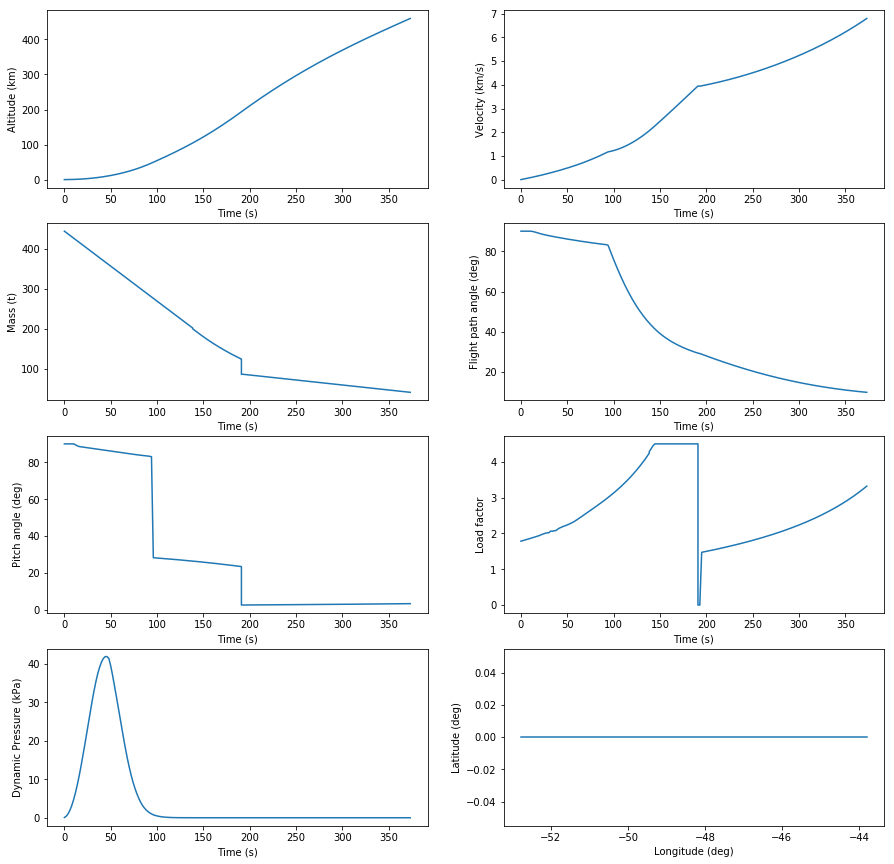

In [8]:
result_vizualization.plots_output(P_out)

### Output data from simulation

In [13]:
data = [[P_out['GLOW'][0]/1e3,
         P_out['Dry_mass_stage_1'][0]/1e3,
         P_out['Dry_mass_stage_2'][0]/1e3,
        P_out['Prop_mass_stage_1'][0]/1e3,
        P_out['Prop_mass_stage_2'][0]/1e3]]
df = pd.DataFrame(data, columns=["GLOW (t)", "Dry_mass_stage_1  (t)", 
                                     "Dry_mass_stage_2  (t)", "Prop_mass_stage_1 (t)", 
                                     "Prop_mass_stage_2 (t)"])
df.round(3)

,GLOW (t),Dry_mass_stage_1 (t),Dry_mass_stage_2 (t),Prop_mass_stage_1 (t),Prop_mass_stage_2 (t)
0,445.547,35.881,5.193,314.852,81.622


## <font color='blue'> Optimization problem:</font>

\begin{eqnarray}
\text{min} & & \text{GLOW}(\mathbf{z}) \\
\text{w.r.t} & & \mathbf{z}=[\text{M}_{prop1},\text{M}_{prop2},\theta_i, \theta_f, \xi, \Delta_t, \Delta_\theta, t_{vertical}, \theta_{cmd} ] \\
\text{s.t.} & & \alpha_{ascent}(\mathbf{z}) \leq 15 \\
 & & NX_{ascent}(\mathbf{z}) \leq 4.5 \\
 & & Pdyn_{ascent}(\mathbf{z}) \leq 40. \\
 & & HeatFlux_{ascent}(\mathbf{z}) \leq 100. \\
 & & \text{Apogee}(\mathbf{z}) = 800. \\
 & & \text{Perigee}_{CoastPhase}(\mathbf{z}) \geq 140. \\
 & & M_{Circularization}(\mathbf{z}) \geq 0. 
 \mathbf{z}_\text{min} \geq \mathbf{z} \geq \mathbf{z}_\text{max}
\end{eqnarray}

with:
- GLOW: Gross-Lift-Off Weight
- $\mathbf{z} \in \mathbb{R}^{10}$, in practice the input variables are normalized into $[0. ,1.]^{10}$
- $\text{M}_{prop1}$: Prop_mass_stage_1
- $\text{M}_{prop2}$: Prop_mass_stage_2
- $\theta_i$: thetacmd_i, pitch angle begining of bilinear phase 
- $\theta_f$: thetacmd_f, pitch angle end of bilinear phase 
- $\xi$: ksi, shape parameter of bilinear phase 
- $\Delta_t$: Pitch_over_duration
- $\Delta_\theta$: Delta_theta_pitch_over
- $t_{vertical}$: Delta_vertical_phase
- $\theta_{cmd}$: command_stage_1_exo (vector of dimension 2)

The constraints are defined in the specification.py file:
- $\alpha_{ascent}$: angle of attack during ascent phase that must be below 15 degrees
- $NX_{ascent}$: axial load factor during ascent phase that must be below 4.5g
- $Pdyn_{ascent}$: dynamic pressure during ascent phase that must be below 40kPa
- $HeatFlux_{ascent}$: heat flux during ascent phase that must be below 100 $W/m^2$
- $\text{Apogee}$: Apogee altitude of coast phase transition orbit must be equal to 800km
- $\text{Perigee}_{CoastPhase}$: Perigee altitude of coast phase transition orbit must be above 140km
- $M_{Circularization}$: remaining propellant mass before circularization must be sufficient to circularize the final orbit 800x800km 

### FPI for optimization

In [5]:
def FPI_optim(x,lowerbnd_exp,upperbnd_exp,Pb):

    Pb.setup(check = False)
    XX = lowerbnd_exp + (upperbnd_exp - lowerbnd_exp)*x
    Pb['Diameter_stage_1'] = 5.0
    Pb['Diameter_stage_2'] = 5.08
    Pb['Mass_flow_rate_stage_1'] = 310.
    Pb['Mass_flow_rate_stage_2'] = 50.
    Pb['Thrust_stage_1'] = 1100.
    Pb['Thrust_stage_2'] = 400.
    Pb['OF_stage_1'] = 5.0
    Pb['OF_stage_2'] = 5.8
    Pb['Pc_stage_1'] = 100.0
    Pb['Pc_stage_2'] = 61.
    Pb['Pe_stage_1'] = 1.0
    Pb['Pe_stage_2'] = 1.0
    Pb['N_eng_stage_1'] = 7.
    Pb['N_eng_stage_2'] = 1.
    Pb['Prop_mass_stage_1'] = XX[0]*1e3
    Pb['Prop_mass_stage_2'] = XX[1]*1e3
    Pb['thetacmd_i'] = XX[2]
    Pb['thetacmd_f'] = XX[3] 
    Pb['ksi'] = XX[4]
    Pb['Pitch_over_duration'] = XX[5]
    Pb['Exit_nozzle_area_stage_1'] = 0.5
    Pb['Exit_nozzle_area_stage_2'] = 0.5
    Pb['Delta_vertical_phase'] = XX[6]
    Pb['Delta_theta_pitch_over'] = XX[7]        
    Pb['command_stage_1_exo'] = XX[8:10] 

    error = 100.
    Pb['Pdyn_max_dim'] = 40.
    k=0
    while error>1. and k<20:
        Pb.run_model()
        error = abs(Pb['Pdyn_max_dim']-Pb['max_pdyn_load_ascent_stage_1']/1e3)
        Pb['Pdyn_max_dim'] = Pb['max_pdyn_load_ascent_stage_1']/1e3
        k = k+1
    return Pb

### Definition of objective function
Definition the objective function for evolutionary algorithm Covariance Matrix Adaptation (CMA-ES) more details on CMA-ES [here](http://cma.gforge.inria.fr/) and [here](https://en.wikipedia.org/wiki/CMA-ES) 
If the constraints are not satisfied, the "penalized objective function" corresponds to the minimization of the constraint violation, and if the constraints are satisfied, $-(900000. - GLOW)/1e5$ is minimized 

In [6]:
def Objective_function(x,lowerbnd_exp,upperbnd_exp,Pb,simu):
    P_out = FPI_optim(x,lowerbnd_exp,upperbnd_exp,Pb)
    GLOW, contraintes = post_traitement.post_traitement(P_out)
    if simu==0: 
        if len(np.where(contraintes>1e-2)[0])==0:            
            return -(900000. - GLOW)/1e5
        else:

            cont = np.sum(contraintes[np.where(contraintes>0)[0]])
            return cont
    else :
        if len(np.where(contraintes>1e-2)[0])==0:
            return GLOW/1e5,-5 
        else:
            return GLOW/1e5,contraintes    

### Definition of lower and upper bounds for the normalization during optimization

In [6]:
lowerbnd_exp = np.array([430.,#Prop_mass_stage_1
                         65., #Prop_mass_stage_2
                         10.,#theta_cmd_i
                         -30.,#theta_cmd_f
                         -1.,#ksi
                         5., #Pitch_over_duration
                         1., #Delta_vertical_phase
                         1., #Delta_theta_pitch_over
                         10.,25.]) #command_stage_1_exo

upperbnd_exp = np.array([470.,#Prop_mass_stage_1
                         90., #Prop_mass_stage_2
                         40.,#theta_cmd_i
                         5.,#theta_cmd_f
                         1.,#ksi
                         25., #Pitch_over_duration
                         5., #Delta_vertical_phase
                         7., #Delta_theta_pitch_over
                         30.,85.]) #command_stage_1_exo

### Definition of CMA-ES options and bounds

In [7]:
lower = np.zeros([1,len(lowerbnd_exp)])
upper = np.ones([1,len(upperbnd_exp)])  
options = cma.CMAOptions()
bound_cma = np.array([lower[0],upper[0]])
options = {'ftarget':-9e7,'tolfun':1e-5,'tolx':1e-6,'seed':2,
           'bounds':[bound_cma[0],bound_cma[1]],'popsize':12,'maxiter':50,'verb_disp': 1}
simu = 0
init = np.ones(len(lowerbnd_exp))*0.5
critere_cma = lambda x: Objective_function(x,lowerbnd_exp,upperbnd_exp,P_obj,simu)

### Running of CMA-ES

In [18]:
res = cma.fmin(critere_cma,init,.2,options)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 10 (seed=2, Thu May  2 18:47:32 2019)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 4.212129758880435e+00 1.0e+00 1.92e-01  2e-01  2e-01 0:05.5
    2     24 4.907626519294887e+00 1.2e+00 1.73e-01  2e-01  2e-01 0:10.7
    3     36 4.361968781200821e+00 1.3e+00 1.73e-01  2e-01  2e-01 0:15.5
    4     48 4.921174616711291e+00 1.4e+00 1.79e-01  2e-01  2e-01 0:21.1
    5     60 3.675503002573549e+00 1.3e+00 1.97e-01  2e-01  2e-01 0:26.5
    6     72 2.221664558531273e+00 1.4e+00 1.94e-01  2e-01  2e-01 0:32.1
    7     84 1.002763528255125e+00 1.6e+00 2.04e-01  2e-01  2e-01 0:37.4
    8     96 2.752132329264278e+00 1.7e+00 2.06e-01  2e-01  2e-01 0:42.1
    9    108 1.913320651676926e-01 1.7e+00 2.03e-01  2e-01  2e-01 0:46.7
   10    120 1.029871832834743e-01 1.9e+00 1.88e-01  2e-01  2e-01 0:51.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    132 -2.937633883497976e+00 1.8

### Results of optimization

In [20]:
print('zbest',res[0])
print('Objective, Penalized Constraint',Objective_function(res[0],lowerbnd_exp,upperbnd_exp,P_obj,1))
print('GLOW (t)', P_obj['GLOW']/1e3)

zbest [0.68465166 0.7327018  0.15091719 0.07824332 0.96328063 0.93641094
 0.83049763 0.43025608 0.59878098 0.9805045 ]
Objective, Penalized Constraint (5.958446298213237, -5)
GLOW (t) [595.84462982]


### Plots of the results of optimization

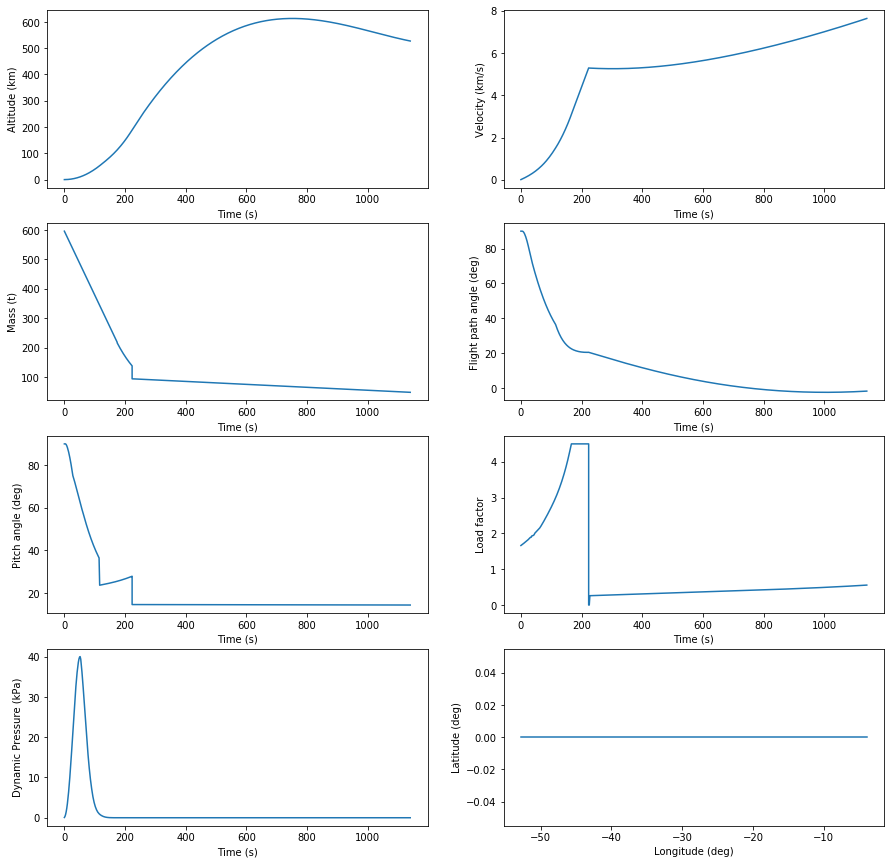

In [21]:
P_out = FPI_optim(res[0],lowerbnd_exp,upperbnd_exp,P_obj)
result_vizualization.plots_output(P_out)

In [22]:
data = [[P_out['GLOW'][0]/1e3,
         P_out['Dry_mass_stage_1'][0]/1e3,
         P_out['Dry_mass_stage_2'][0]/1e3,
        P_out['Prop_mass_stage_1'][0]/1e3,
        P_out['Prop_mass_stage_2'][0]/1e3]]
df = pd.DataFrame(data, columns=["GLOW (t)", "Dry_mass_stage_1  (t)", 
                                     "Dry_mass_stage_2  (t)", "Prop_mass_stage_1 (t)", 
                                     "Prop_mass_stage_2 (t)"])
df.round(3)

,GLOW (t),Dry_mass_stage_1 (t),Dry_mass_stage_2 (t),Prop_mass_stage_1 (t),Prop_mass_stage_2 (t)
0,595.845,41.894,5.247,457.386,83.318
